# Lab 4: Sampling and Randomness for Penn State DS 200

## Acknowledgements: 
### This lab is adopted from a lab of data 8 course at University of California, Berkeley.  I also wish to thank Dr. Matthew Beckman (in Department of Statistics) for contributing to the revision of the lab for the purpose of its use in DS 200.

We will introduce the important two important concepts in statistics: sampling and randomness [randomness](https://www.inferentialthinking.com/chapters/09/Randomness.html).

The data used in this lab will contain salary data and other statistics for basketball players from the 2014-2015 NBA season. This data was collected from the following sports analytic sites: [Basketball Reference](http://www.basketball-reference.com) and [Spotrac](http://www.spotrac.com).

First, install the datascience module by running the cell below, which will take some time. Wait untill the installation process completes.

In [1]:
!pip install datascience

     |████████████████████████████████| 51kB 3.2MB/s eta 0:00:011
     |████████████████████████████████| 92kB 4.3MB/s  eta 0:00:01
     |████████████████████████████████| 13.0MB 17kB/s  eta 0:00:01     |███                             | 1.2MB 12.9MB/s eta 0:00:01     |███▎                            | 1.3MB 12.9MB/s eta 0:00:01     |█████████▍                      | 3.8MB 9.2MB/s eta 0:00:02     |█████████████                   | 5.3MB 9.2MB/s eta 0:00:01     |███████████████████████▌        | 9.6MB 1.7MB/s eta 0:00:03     |██████████████████████████      | 10.6MB 416kB/s eta 0:00:06     |██████████████████████████▊     | 10.9MB 416kB/s eta 0:00:06
     |████████████████████████████████| 215kB 8.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1d/e7/fd8b501e7a6dfe492a433deb7b9d833d39ca74916fa8bc63dd1a4947a671/Jinja2-2.10.1-py2.py3-none-any.whl
     |████████████████████████████████| 92kB 3.5MB/s eta 0:00:01
  Created wheel for datascience: filename=datascience-

Successfully built datascience docopt
  Found existing installation: Jinja2 2.8
    Uninstalling Jinja2-2.8:
      Successfully uninstalled Jinja2-2.8
  Found existing installation: matplotlib 2.1.1
    Uninstalling matplotlib-2.1.1:
      Successfully uninstalled matplotlib-2.1.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Run this cell to import relevant Python modules. Please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Don't change this cell; just run it. 
#from client.api.notebook import Notebook
#ok = Notebook('lab05.ok')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### Python: Conditionals and Random Choice

In Python, the boolean data type contains only two unique values:  `True` and `False`. Expressions containing comparison operators such as `<` (less than), `>` (greater than), and `==` (equal to) evaluate to Boolean values. 

Run the cell below to see an example of a comparison operator in action.

In [3]:
3 > 1 + 1

True

We can even assign the result of a comparison operation to a variable.

In [4]:
result = 10 / 2 == 5
result

True

Arrays are compatible with comparison operators. The output is an array of boolean values.

In [5]:
make_array(1, 5, 7, 8, 3, -1) > 3

array([False,  True,  True,  True, False, False])

One day, when you come home after a long week, you see a hot bowl of nachos waiting on the dining table! Let's say that whenever you take a nacho from the bowl, it will either have only **cheese**, only **salsa**, **both** cheese and salsa, or **neither** cheese nor salsa (a sad tortilla chip indeed). 

Let's try and simulate taking nachos from the bowl at random using the function, `np.random.choice(...)`.

### `np.random.choice`

`np.random.choice` picks one item at random from the given array. It is equally likely to pick any of the items. Run the cell below SEVERAL times, and observe how the results may differ for different runs.

In [6]:
nachos = make_array('cheese', 'salsa', 'both', 'neither')
np.random.choice(nachos)

'both'

To repeat this process multiple times, pass in an int `n` as the second argument. By default, `np.random.choice` samples **with replacement** and returns an *array* of items. 

Run the next cell to see an example of sampling with replacement 10 times from the `nachos` array.

In [7]:
np.random.choice(nachos, 10)

array(['both', 'neither', 'neither', 'cheese', 'neither', 'cheese',
       'neither', 'neither', 'neither', 'cheese'], dtype='<U7')

## 2. Sampling Basketball Data

Run the cell below to load the player and salary data. 

In [8]:
player_data = Table().read_table("player_data.csv")
salary_data = Table().read_table("salary_data.csv")
full_data = salary_data.join("PlayerName", player_data, "Name")

# The show method immediately displays the contents of a table. 
# This way, we can display the top of two tables using a single cell.
player_data.show(3)
salary_data.show(3)
full_data.show(3)

Name,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
James Harden,25,HOU,81,459,565,154,60,321,2217
Chris Paul,29,LAC,82,376,838,156,15,190,1564
Stephen Curry,26,GSW,80,341,619,163,16,249,1900


PlayerName,Salary
Kobe Bryant,23500000
Amar'e Stoudemire,23410988
Joe Johnson,23180790


PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
A.J. Price,62552,28,TOT,26,32,46,7,0,14,133
Aaron Brooks,1145685,30,CHI,82,166,261,54,15,157,954
Aaron Gordon,3992040,19,ORL,47,169,33,21,22,38,243


Rather than getting data on every player, imagine that we had gotten data on only a smaller subset of the players.  For 492 players, it's not so unreasonable to expect to see all the data, but usually we aren't so lucky.  Instead, we often make statistical inferences about a large underlying population using a smaller sample.

### Using a Sample to Estimate the Population

A *statistical inference* is a statement about some statistic of the underlying population, such as "the average salary of NBA players in 2014 was $3".  You may have heard the word "inference" used in other contexts.  It's important to keep in mind that statistical inferences, unlike, say, logical inferences, can be wrong.

A general strategy for inference using samples is to estimate statistics of the population by computing the same statistics on a sample.  This strategy sometimes works well and sometimes doesn't.  The degree to which it gives us useful answers depends on several factors, and we'll touch lightly on a few of those today.

One very important factor in the utility of samples is how they were gathered.  We have prepared some example sample datasets to simulate inference from different kinds of samples for the NBA player dataset.  Later we'll ask you to create your own samples to see how they behave.

To save typing and increase the clarity of your code, we will package the analysis code into a few functions. This will be useful in the rest of the lab as we will repeatedly need to create histograms and collect summary statistics from that data.

We've defined the `histograms` function below, which takes a table with columns `Age` and `Salary` and draws a histogram for each one. It uses bin widths of 1 year for `Age` and $1,000,000 for `Salary`.

Two histograms should be displayed below


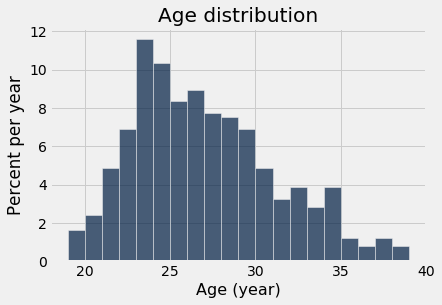

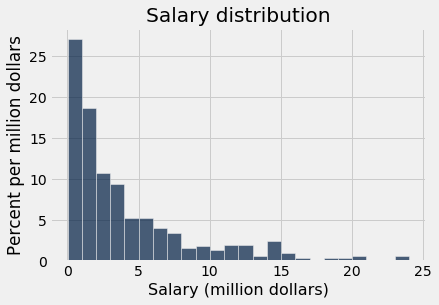

In [9]:
def histograms(t):
    ages = t.column('Age')
    salaries = t.column('Salary')/1000000
    t1 = t.drop('Salary').with_column('Salary', salaries)
    age_bins = np.arange(min(ages), max(ages) + 2, 1) 
    salary_bins = np.arange(min(salaries), max(salaries) + 1, 1)
    t1.hist('Age', bins=age_bins, unit='year')
    plt.title('Age distribution')
    t1.hist('Salary', bins=salary_bins, unit='million dollars')
    plt.title('Salary distribution') 
    
histograms(full_data)
print('Two histograms should be displayed below')

### Convenience sampling
One sampling methodology, which is **generally a bad idea**, is to choose players who are somehow convenient to sample.  For example, you might choose players from one team who are near your house, since it's easier to survey them.  This is called, somewhat pejoratively, *convenience sampling*.

Suppose you survey only *relatively new* players with ages less than 22.  (The more experienced players didn't bother to answer your surveys about their salaries.)

### Exercise 1.
Assign `convenience_sample` to a subset of `full_data` that contains only the rows for players under the age of 22.
#### Hint: where("Age", are.above(...)) or where("Age", are.below(..)) can be useful here.

In [10]:
convenience_sample = full_data.where('Age', are.below(22))
convenience_sample

PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
Aaron Gordon,3992040,19,ORL,47,169,33,21,22,38,243
Alex Len,3649920,21,PHO,69,454,32,34,105,74,432
Andre Drummond,2568360,21,DET,82,1104,55,73,153,120,1130
Andrew Wiggins,5510640,19,MIN,82,374,170,86,50,177,1387
Anthony Bennett,5563920,21,MIN,57,216,48,27,16,36,298
Anthony Davis,5607240,21,NOP,68,696,149,100,200,95,1656
Archie Goodwin,1112280,20,PHO,41,74,44,18,9,48,231
Ben McLemore,3026280,21,SAC,82,241,140,77,19,138,996
Bradley Beal,4505280,21,WAS,63,241,194,76,18,123,962
Bruno Caboclo,1458360,19,TOR,8,2,0,0,1,4,10


### You can generate basic statistics (e.g., min value, max value, medium, sum) for each column using .stats() of Table.

In [11]:
full_data.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,A.J. Price,14409,19,ATL,1,0,0,0,0,0,0
max,Zoran Dragic,2.35e+07,38,WAS,83,1226,838,163,200,321,2217
median,,2.34926e+06,26,,61,176,69.5,32,14,55.5,420.5
sum,,2.10073e+09,13056,,25981,106504,54202,19031,11797,33725,246035


### Exercise 2
Comput the statistical information of the players generated by the convenience sample.  Compare the statistical information of Salary between the entire population with those generated from convenient sample.  Write your answer in the text cell after the next code cell (which starts with "Answer to Exercise 2")

In [13]:
convenience_sample.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,Aaron Gordon,507336,19,ATL,1,0,0,0,0,1,2
max,Zach LaVine,5.60724e+06,21,WAS,82,1104,533,142,200,203,1656
median,,1.92048e+06,21,,56,150.5,60,33,12,50,352.5
sum,,1.04875e+08,896,,2280,9288,3993,1792,1403,3069,19425


### Answer to Exercise 2:  The minimum salary from convenient sample is much more than the entire population's. But the maximum salary for convenient sample is less than that from entire population. The median salary also varies a lot. Overall, the salary statistics from convenient sample and the entire population varies a lot.

Next, we'll compare the convenience sample salaries with the full data salaries in a single histogram. To do that, we'll need to use the `bin_column` option of the `hist` method, which indicates that all columns are counts of the bins in a particular column. The following cell does not require any changes; **just run it**.

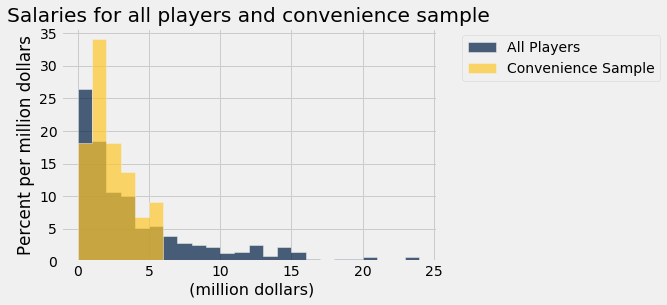

In [14]:
def compare_salaries(first, second, first_title, second_title):
    """Compare the salaries in two tables."""
    first_salary_in_millions = first.column('Salary')/1000000
    second_salary_in_millions = second.column('Salary')/1000000
    first_tbl_millions = first.drop('Salary').with_column('Salary', first_salary_in_millions)
    second_tbl_millions = second.drop('Salary').with_column('Salary', second_salary_in_millions)
    max_salary = max(np.append(first_tbl_millions.column('Salary'), second_tbl_millions.column('Salary')))
    bins = np.arange(0, max_salary+1, 1)
    first_binned = first_tbl_millions.bin('Salary', bins=bins).relabeled(1, first_title)
    second_binned = second_tbl_millions.bin('Salary', bins=bins).relabeled(1, second_title)
    first_binned.join('bin', second_binned).hist(bin_column='bin', unit='million dollars')
    plt.title('Salaries for all players and convenience sample')

compare_salaries(full_data, convenience_sample, 'All Players', 'Convenience Sample')

### Exercise 3.
Does the convenience sample give us an accurate picture of the salary of the full population? Would you expect it to, in general?  Before you move on, write a short answer in English below.  You can refer to the statistics calculated above or perform your own analysis.

### Your answer for Exercise 3: 
The convenience sample does not give us an accurate picture of the salary of the full population. I would expect it to, but it is apparently not the case. Then convenience sample only has 5 million dollars, where the all players have up to 15 million dollars. The percent per million dollar between these two groups are also very different.

### Simple random sampling
A more justifiable approach is to sample uniformly at random from the players.  In a **simple random sample (SRS) without replacement**, we ensure that each player is selected at most once. Imagine writing down each player's name on a card, putting the cards in an box, and shuffling the box.  Then, pull out cards one by one and set them aside, stopping when the specified sample size is reached.

## Size of Random Sampling 
Sometimes, it’s useful to take random samples even when we have the data for the whole population. It helps us understand sampling accuracy.

### `sample`

The table method `sample` produces a random sample from the table. By default, it draws at random *with replacement* from the rows of a table. It takes in the sample size as its argument and returns a *table* with only the rows that were selected. The optional argument `with_replacement=True` specifies that the sample should be drawn without replacement.

Run the cell below to see an example call.

In [15]:
# Just run this cell

tiny_sample=full_data.sample(20, with_replacement=True)

In [16]:
tiny_sample.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,Boris Diaw,92514,19,BRK,7,4,3,1,0,3,20
max,Xavier Henry,1.48989e+07,36,WAS,82,748,288,90,110,126,1001
median,,2.83295e+06,28,,57.5,164.5,73,29,12.5,51,292
sum,,8.67056e+07,545,,1004,4581,1729,571,462,1191,7470


### Exercise 4
Produce a simple random sample of size 44 from `full_data`. Run your analysis on it again.  Run the cell a few times to see how the statistics change across different samples.

- How much does the median salary change across samples? 
- How much does the median salary of the sample differ from the median salary of the whole population?

In [28]:
my_small_srswor_data = full_data.sample(44, with_replacement=True)
my_small_srswor_data

PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
Robbie Hummel,880000,25,MIN,45,134,27,16,9,18,198
J.J. Redick,6792500,30,LAC,78,167,137,39,8,95,1277
Damjan Rudez,1100000,28,IND,68,47,53,16,5,47,323
Enes Kanter,5694674,22,TOT,75,671,55,36,29,145,1163
Bryce Cotton,92514,22,UTA,15,18,15,4,0,12,80
Nikola Vucevic,2751260,24,ORL,74,810,147,54,54,148,1428
Brandon Rush,1145685,29,GSW,33,41,12,5,12,11,30
Greivis Vasquez,6400000,28,TOR,82,216,302,46,10,119,775
Manu Ginobili,7000000,37,SAS,70,211,293,67,20,154,738
James Harden,14728844,25,HOU,81,459,565,154,60,321,2217


In [29]:
my_small_srswor_data.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,Allen Crabbe,92514,19,BOS,5,1,0,0,0,1,2
max,Udonis Haslem,2.31808e+07,37,WAS,82,810,565,154,66,321,2217
median,,2.732e+06,26,,67,182.5,62.5,39,11.5,50,393
sum,,1.65912e+08,1159,,2547,8552,5524,1826,699,3171,23975


In [19]:
full_data.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,A.J. Price,14409,19,ATL,1,0,0,0,0,0,0
max,Zoran Dragic,2.35e+07,38,WAS,83,1226,838,163,200,321,2217
median,,2.34926e+06,26,,61,176,69.5,32,14,55.5,420.5
sum,,2.10073e+09,13056,,25981,106504,54202,19031,11797,33725,246035


### Answer to Exercise 4: 
The median change very differntly across samples. Sometimes it's 0.3e+06 bigger than before, then 0.3e+06 less than before. Sometimes it is 1e+06 bigger than before. So there is no pattern for its changing.
The median salary for the current sample is around 0.4e+06 more than the median salary from the whole population. 

### Exercise 5
As in the previous question, analyze several simple random samples of size 100 from `full_data`.  
- Do the histogram shapes seem to change more or less across samples of 100 than across samples of size 44? 
- How does the sample median salary and histograms of the larger sample compare to the median salary and histogram of the entire population?
- Is there a relationship between the size of a sample and the deviation of the sample's median salary from the median of the entire population?

In [42]:
my_large_srswor_data = full_data.sample(100, with_replacement=True)
my_large_srswor_data.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,A.J. Price,29843,19,ATL,2,0,0,0,0,0,0
max,Xavier Henry,1.93173e+07,37,WAS,82,919,565,154,200,321,2217
median,,2.09186e+06,26,,56.5,168.5,72,27,11.5,50.5,402.5
sum,,3.47857e+08,2627,,5096,20223,10040,3782,2184,6485,48580


In [39]:
full_data.stats()

statistic,PlayerName,Salary,Age,Team,Games,Rebounds,Assists,Steals,Blocks,Turnovers,Points
min,A.J. Price,14409,19,ATL,1,0,0,0,0,0,0
max,Zoran Dragic,2.35e+07,38,WAS,83,1226,838,163,200,321,2217
median,,2.34926e+06,26,,61,176,69.5,32,14,55.5,420.5
sum,,2.10073e+09,13056,,25981,106504,54202,19031,11797,33725,246035


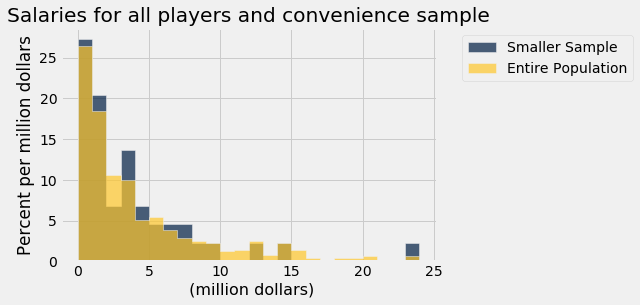

In [44]:
compare_salaries(my_small_srswor_data, full_data, 'Smaller Sample', 'Entire Population')

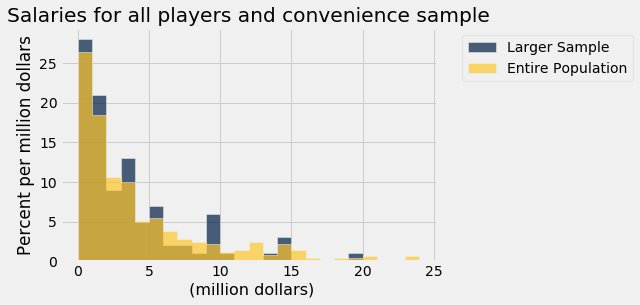

In [43]:
compare_salaries(my_large_srswor_data, full_data, 'Larger Sample', 'Entire Population')

### Answer to Exercise 5:
The histogram shapes seem to change less across samples of 100 than 44.
The sample median salary of the larger sample is close to the median salry of the full population, but is still varies a lot. The histogram of the larger sample is almost the shape of the histogram of the full population. They are very close.
The bigger the size of a sample is, the smaller deviation is. 

Congratulations, you're done with Lab 4!  Be sure to 
- **Save and Checkpoint your notebook** from the `File` menu. 
- **Download the notebook in two formats: .ipynb and .pdf.
- **Submit both files to Canvas as Lab 4 Assignment.